In [1]:
!pip install tensorflow_model_optimization 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 7.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import tensorflow_model_optimization as tfmot
import json
import zipfile
import os
import gc
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BASE_TRAIN_PATH = "/kaggle/input/asl-signs/"
TRAIN_FILE = "/kaggle/input/asl-signs/train.csv"
INDEX_MAP_FILE = '/kaggle/input/asl-signs/sign_to_prediction_index_map.json'
MODEL_OUT_PATH = '/kaggle/working/modelie'

INFERENCE_MODEL_OUT_PATH = '/kaggle/working/inference-model/modelie'
ZIPPED_SUBMISSION_OUT_PATH = '/kaggle/working/submission.zip'
CHECK_POINT_PATH = 'kaggle/working/check-point/cp.ckpt'

epochs = 200
batch_size = 300

training = True
rows_per_frame = 543 #Number of landmarks per frame 
num_classes = 250 
pruning = False
dropout_rate = .3

# MIN MAX AVG Frames 
# 537
# 2
# 37.93502122209638
max_length = 30 # length that input is padded/truncated to 
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

NUM_FRAMES = 15
SEGMENTS = 3

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33
ROWS_PER_FRAME = 543

## average over the entire face, and the entire 'pose'

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]

left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))

point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]


In [3]:
# Data Loading 
train = pd.read_csv(TRAIN_FILE)
with open(INDEX_MAP_FILE, 'r') as f: 
    index_map = json.load(f)

train['label'] = train['sign'].map(lambda x: index_map[x])

x_ragged = []
y =  []

# for i in tqdm(range(len(train))): 
for i in tqdm(range(int(len(train)))):
    data_columns  = ['x', 'y', 'z']
    
    data = pd.read_parquet(os.path.join(BASE_TRAIN_PATH, train.iloc[i].path), columns=data_columns)
    
    n = int(len(data)/rows_per_frame)
    
    data = data.values.reshape(n, rows_per_frame, len(data_columns)).astype(np.float32)
    
    data = np.nan_to_num(data[:, point_landmarks, :]) # filter for the relevant pose landmarks 
    
    #avg_data = np.array([data[j:j+3].sum(axis=0)/np.ones((82, 3))*3 for j in range(int(data.shape[0]/3))])
#     if n>2: 
#         avg_data = np.array([np.nanmean(data[p:p+2], axis = 0) for p in range(int(n/2))])
    
#         avg_data = np.reshape(avg_data, (int(n/2), len(point_landmarks)*3)).astype(np.float32) # flatten the x,y,z dimension of data again 
#     else: 
    avg_data = np.reshape(data, (n, len(point_landmarks)*3)).astype(np.float32)
            
    
    x_ragged.append(avg_data)
    
    y.append(train.iloc[i].label)


x_ragged = np.array(x_ragged)

y = np.array(y)

x = tf.keras.utils.pad_sequences(
    x_ragged, padding="post", truncating="post", maxlen = max_length, dtype=np.float32
)

del x_ragged 
gc.collect()

# print(x_ragged.shape, y.shape)
# (examples, only relevant landmarks * dimension of coordinates)
# (94477, 82*3) (94477,) 


  0%|          | 0/94477 [00:00<?, ?it/s]

18

In [4]:
class FeatureGenTF(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        x = tf.gather(x, point_landmarks, axis=1)
        x = tf.image.resize_with_pad(x, max_length, len(point_landmarks))
        x = tf.concat([x[...,i] for i in range(3)], -1) #Flatten
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x = tf.expand_dims(x,0) # THIS IS SAYING BATCH SIZE ONE TO MODEL YEAAAA
        return x

In [5]:
# Training Code 
def get_model(x, y): 
    model = tf.keras.Sequential([
        # the hidden ReLU layers
        tf.keras.Input(shape=(max_length, len(point_landmarks)*3), dtype=np.float32), 
        tf.keras.layers.Masking(mask_value=0, input_shape=(max_length, len(point_landmarks)*3)),
        tf.keras.layers.Dense(units=256, activation='relu'), # Generally want hidden layers to be between the size of the input and output layers 
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LayerNormalization(), 
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(256),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        # the linear output layer 
        tf.keras.layers.Dense(units = num_classes, activation='softmax', name='outie'), # Output size is <256>
    ])
    
    model.compile(optimizer = "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model 

model = get_model(x,y) 

if training: 
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1) 
    
del x , y
gc.collect()


13653

In [6]:

callbacks = [
        EarlyStopping(
                monitor = "val_accuracy",
                min_delta = 0, # minimium amount of change to count as an improvement
                patience = 5, # how many epochs to wait before stopping
                restore_best_weights=True),
    
        ReduceLROnPlateau(monitor = "val_accuracy",
            factor = 0.5,
            patience = 5)
            ]

history = model.fit(X_train, Y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              validation_data = (X_val, Y_val), 
              callbacks=[callbacks])

loss, acc = model.evaluate(X_val, Y_val, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/200
189/189 [==============================] - 33s 120ms/step - loss: 5.2759 - accuracy: 0.0147 - val_loss: 4.8081 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 2/200
189/189 [==============================] - 19s 101ms/step - loss: 4.3576 - accuracy: 0.0836 - val_loss: 3.9741 - val_accuracy: 0.1380 - lr: 0.0010
Epoch 3/200
189/189 [==============================] - 21s 109ms/step - loss: 3.7723 - accuracy: 0.1622 - val_loss: 3.4426 - val_accuracy: 0.2276 - lr: 0.0010
Epoch 4/200
189/189 [==============================] - 20s 104ms/step - loss: 3.3893 - accuracy: 0.2239 - val_loss: 3.1909 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 5/200
189/189 [==============================] - 20s 105ms/step - loss: 3.1296 - accuracy: 0.2716 - val_loss: 2.9584 - val_accuracy: 0.3151 - lr: 0.0010
Epoch 6/200
189/189 [==============================] - 21s 110ms/step - loss: 2.9287 - accuracy: 0.3125 - val_loss: 2.8897 - val_accuracy: 0.3278 - lr: 0.0010
Epoch 7/200
189/189 [=========================

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 30, 246)           0         
                                                                 
 dense (Dense)               (None, 30, 256)           63232     
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 layer_normalization (LayerN  (None, 30, 256)          512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 30, 256)           65792     
                                                                 
 dropout_1 (Dropout)         (None, 30, 256)           0         
                                                        

In [8]:
# pruning_params = {
#       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
#                                                                final_sparsity=0.80,
#                                                                begin_step=0,
#                                                                end_step=2)
# }
# prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# pruned_model = prune_low_magnitude(model, **pruning_params)


# callbacks =   [tfmot.sparsity.keras.UpdatePruningStep()]


# pruned_model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# pruned_model.fit(X_train, Y_train, batch_size = batch_size, epochs =2, validation_data = (X_val, Y_val), callbacks = callbacks)

# loss, acc = pruned_model.evaluate(X_val, Y_val, verbose=2)

# pruned_model.summary()

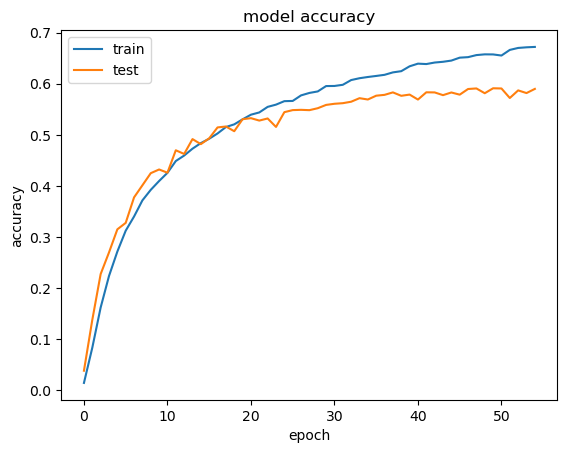

In [9]:
import matplotlib.pyplot as plt

print(history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

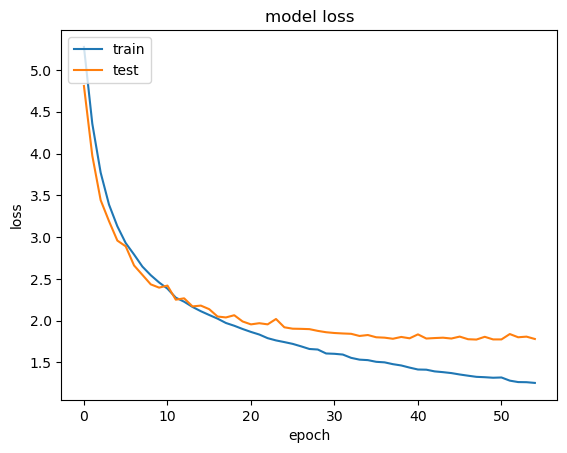

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
preprocessing = FeatureGenTF()

def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs") 
    x = preprocessing(inputs)
    x = model(x)
    
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return inference_model

In [12]:

inference_model = get_inference_model(model)

converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"

with open(model_path, 'wb') as f:
    f.write(tflite_model)

print("MODEL SIZE")
print(os.stat('model.tflite').st_size)

!zip submission.zip $model_path

inference_model.summary(expand_nested=True)

MODEL SIZE
2932540
  adding: model.tflite (deflated 9%)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 543, 3)]          0         
                                                                 
 feature_gen_tf (FeatureGenT  (1, 30, 246)             0         
 F)                                                              
                                                                 
 sequential (Sequential)     (None, 250)               719098    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| masking (Masking)         (None, 30, 246)           0         |
|                                                               |
| dense (Dense)             (None, 30, 256)           63232     |
|                                                               |
| dropout (Dropout)         (None, 30, 256)           0         |
|    

In [13]:
# !pip install tflite-runtime

In [14]:
# import tflite_runtime.interpreter as tflite

# def load_relevant_data_subset(pq_path):
#     data_columns = ['x', 'y', 'z']
#     data = pd.read_parquet(pq_path, columns=data_columns)
#     n_frames = int(len(data) / ROWS_PER_FRAME)
#     data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
#     return data.astype(np.float32)


# frames = load_relevant_data_subset(os.path.join(BASE_TRAIN_PATH, train.iloc[11].path))

# interpreter = tflite.Interpreter(model_path)

# found_signatures = list(interpreter.get_signature_list().keys())
# prediction_fn = interpreter.get_signature_runner("serving_default")
# output = prediction_fn(inputs=frames)
# sign = np.argmax(output["outputs"])
# print(train.iloc[1].label)
